# Лабораторная работа №2
Необходимые данные можно скачать [здесь](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data).

In [14]:
# Установка необходимых библиотек
%pip install folium scikit-learn pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Создаем необходимые директории (если их нет)
!mkdir -p data/input/laboratory_work2 data/output/laboratory_work2
print("✓ Директории созданы")

✓ Директории созданы


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style="darkgrid")
np.random.seed(0)

## Часть 0. Подготовка

### Задание 1: Загрузка данных

In [17]:
# Загружаем данные
df = pd.read_csv("data/input/laboratory_work2/train.csv")
print(f"Размер датасета: {df.shape}")
print("\nПервые строки:")
df.head()

Размер датасета: (1458644, 11)

Первые строки:


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [18]:
# Удаляем dropoff_datetime
df = df.drop('dropoff_datetime', axis=1)

# Преобразуем pickup_datetime в datetime объект
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

print("Информация о данных:")
df.info()

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


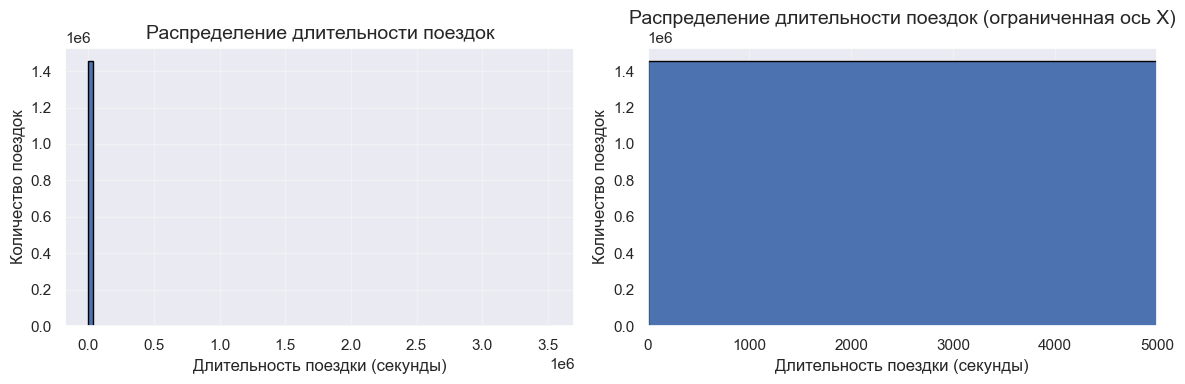

Статистика по trip_duration:
count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64


<Figure size 640x480 with 0 Axes>

In [19]:
# Изучаем распределение целевой переменной
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['trip_duration'], bins=100, edgecolor='black')
plt.xlabel('Длительность поездки (секунды)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение длительности поездок', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df['trip_duration'], bins=100, edgecolor='black')
plt.xlabel('Длительность поездки (секунды)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение длительности поездок (ограниченная ось X)', fontsize=14)
plt.xlim(0, 5000)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trip_duration_distribution.png")

print(f"Статистика по trip_duration:\n{df['trip_duration'].describe()}")

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ**: Распределение сильно скошено вправо. Большинство поездок имеют небольшую длительность (до 1000-2000 секунд). Большинство поездок короткие, но есть редкие очень длинные поездки.

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ**: RMSLE менее чувствителен к выбросам и большим значениям, чем RMSE. Для данных с сильной правосторонней асимметрией (как у нас) RMSE будет сильно зависеть от нескольких очень больших значений, что сделает метрику менее репрезентативной для типичных поездок. RMSLE "сжимает" большие значения через логарифм, делая метрику более справедливой для всего диапазона значений.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:

Обозначим $\hat{y}_i = \log(y_i + 1)$ и $\hat{a}(x_i) = \log(a(x_i) + 1)$.

RMSLE для модели $a$:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (\hat{y}_i - \hat{a}(x_i))^2}$$

MSE для модели $\hat{a}$:
$$\text{MSE}(X, \hat{y}, \hat{a}) = \frac{1}{\ell}\sum_{i=1}^{\ell} (\hat{y}_i - \hat{a}(x_i))^2$$

Видно, что $\text{RMSLE}^2 = \text{MSE}$, следовательно минимизация RMSLE эквивалентна минимизации MSE для логарифмированных значений.

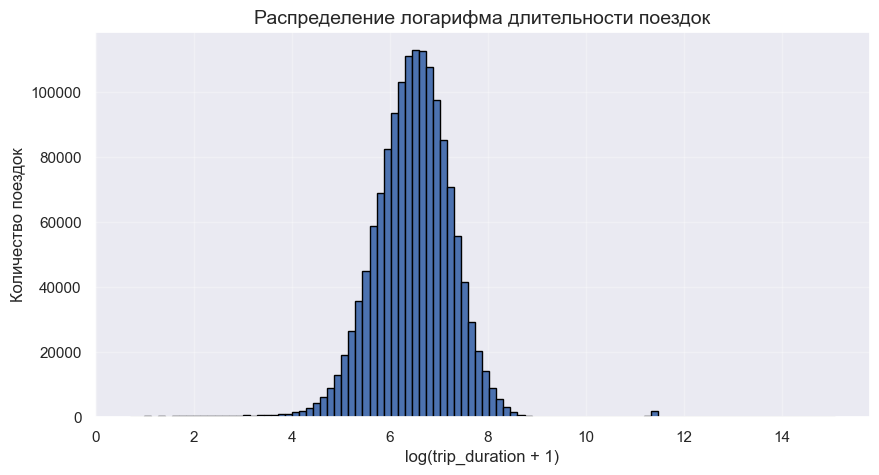

Статистика по log_trip_duration:
count    1.458644e+06
mean     6.466978e+00
std      7.957595e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.496775e+00
75%      6.981006e+00
max      1.507575e+01
Name: log_trip_duration, dtype: float64


<Figure size 640x480 with 0 Axes>

In [20]:
# Добавляем логарифм таргета
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# Удаляем исходный таргет
df = df.drop('trip_duration', axis=1)

# Визуализируем распределение логарифма
plt.figure(figsize=(10, 5))
plt.hist(df['log_trip_duration'], bins=100, edgecolor='black')
plt.xlabel('log(trip_duration + 1)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение логарифма длительности поездок', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig("data/output/laboratory_work2/log_trip_duration_distribution.png")

print(f"Статистика по log_trip_duration:\n{df['log_trip_duration'].describe()}")

Распределение стало гораздо более симметричным и близким к нормальному, что лучше для линейной регрессии.

In [21]:
# Функция для расчета RMSLE
def rmsle(log1p_y_true, log1p_y_pred):
    """Вычисляет RMSLE для логарифмированных значений"""
    return np.sqrt(mean_squared_error(log1p_y_true, log1p_y_pred))

# Наилучшее константное предсказание - это среднее значение логарифма
best_const = df['log_trip_duration'].mean()
rmsle_best_const = rmsle(df['log_trip_duration'], np.full(len(df), best_const))

print(f"Наилучшее константное предсказание: {best_const:.4f}")
print(f"RMSLE для константного предсказания: {rmsle_best_const:.5f}")

assert np.allclose(rmsle_best_const, 0.79575, 1e-4), "Проверьте расчет RMSLE"

Наилучшее константное предсказание: 6.4670
RMSLE для константного предсказания: 0.79576


## Часть 1. Изучаем pickup_datetime (2 балла)

### Задание 2: Анализ времени

In [22]:
# Извлекаем временные признаки
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month
df['date'] = df['pickup_datetime'].dt.date

print("Добавлены временные признаки")

Добавлены временные признаки


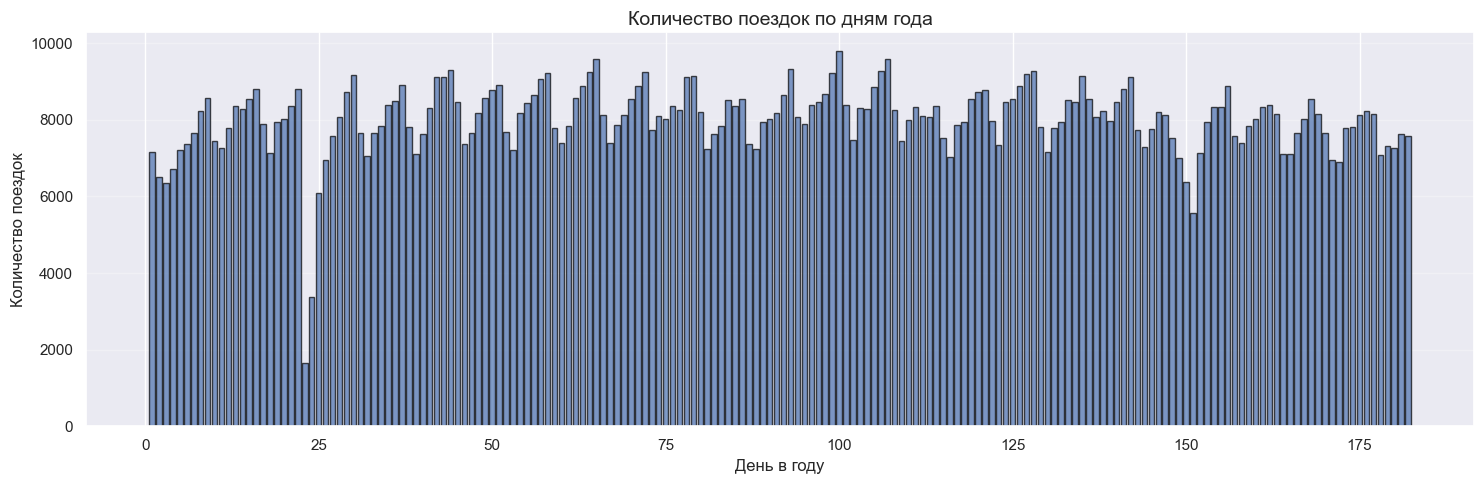


Аномальные дни (с малым количеством поездок):
День 2: 2016-01-02 - 6512 поездок
День 3: 2016-01-03 - 6353 поездок
День 4: 2016-01-04 - 6725 поездок
День 23: 2016-01-23 - 1648 поездок
День 24: 2016-01-24 - 3383 поездок
День 25: 2016-01-25 - 6084 поездок
День 26: 2016-01-26 - 6941 поездок
День 150: 2016-05-29 - 6372 поездок
День 151: 2016-05-30 - 5570 поездок
День 172: 2016-06-20 - 6910 поездок


<Figure size 640x480 with 0 Axes>

In [23]:
# График количества поездок по дням
plt.figure(figsize=(15, 5))
daily_counts = df.groupby('day_of_year').size()
plt.bar(daily_counts.index, daily_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('День в году', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Количество поездок по дням года', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_day.png")

# Найдем аномальные дни
anomaly_threshold = daily_counts.quantile(0.05)
anomalous_days = daily_counts[daily_counts < anomaly_threshold]
print(f"\nАномальные дни (с малым количеством поездок):")
for day in anomalous_days.index:
    date = pd.Timestamp(year=2016, month=1, day=1) + pd.Timedelta(days=int(day)-1)
    print(f"День {day}: {date.strftime('%Y-%m-%d')} - {anomalous_days[day]} поездок")

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: Два основных периода с низким количеством поездок:
1. **23-24 января 2016** - Снежная буря "Джонас" (Blizzard Jonas), одна из сильнейших метелей в истории Нью-Йорка. Город был практически парализован.
2. **Период вокруг 1 января** - Новогодние праздники, когда многие люди не работают и меньше пользуются такси.

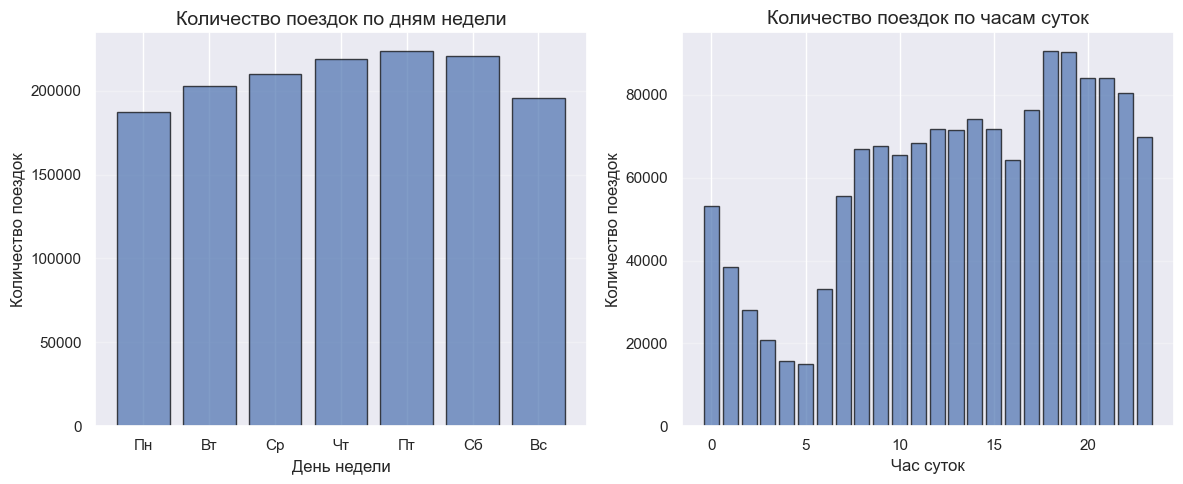

<Figure size 640x480 with 0 Axes>

In [24]:
# График по дням недели
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
weekday_counts = df.groupby('day_of_week').size()
plt.bar(range(7), weekday_counts.values, edgecolor='black', alpha=0.7)
plt.xticks(range(7), day_names)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Количество поездок по дням недели', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# График по часам
plt.subplot(1, 2, 2)
hour_counts = df.groupby('hour').size()
plt.bar(hour_counts.index, hour_counts.values, edgecolor='black', alpha=0.7)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Количество поездок по часам суток', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_weekday_hour.png")

### Задание 3: Детальный анализ времени

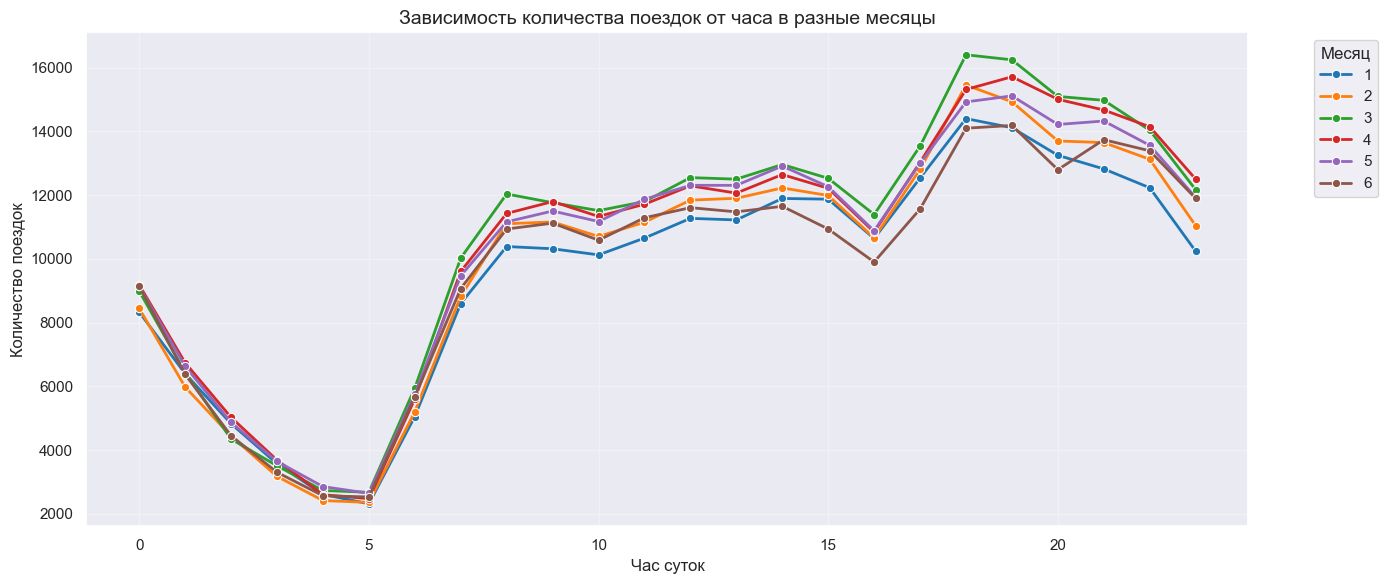

<Figure size 640x480 with 0 Axes>

In [25]:
# График зависимости количества поездок от часа для разных месяцев
plt.figure(figsize=(14, 6))

hour_month_counts = df.groupby(['hour', 'month']).size().reset_index(name='count')
sns.lineplot(data=hour_month_counts, x='hour', y='count', hue='month',
             palette='tab10', marker='o', linewidth=2)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Зависимость количества поездок от часа в разные месяцы', fontsize=14)
plt.legend(title='Месяц', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_month_hour.png")

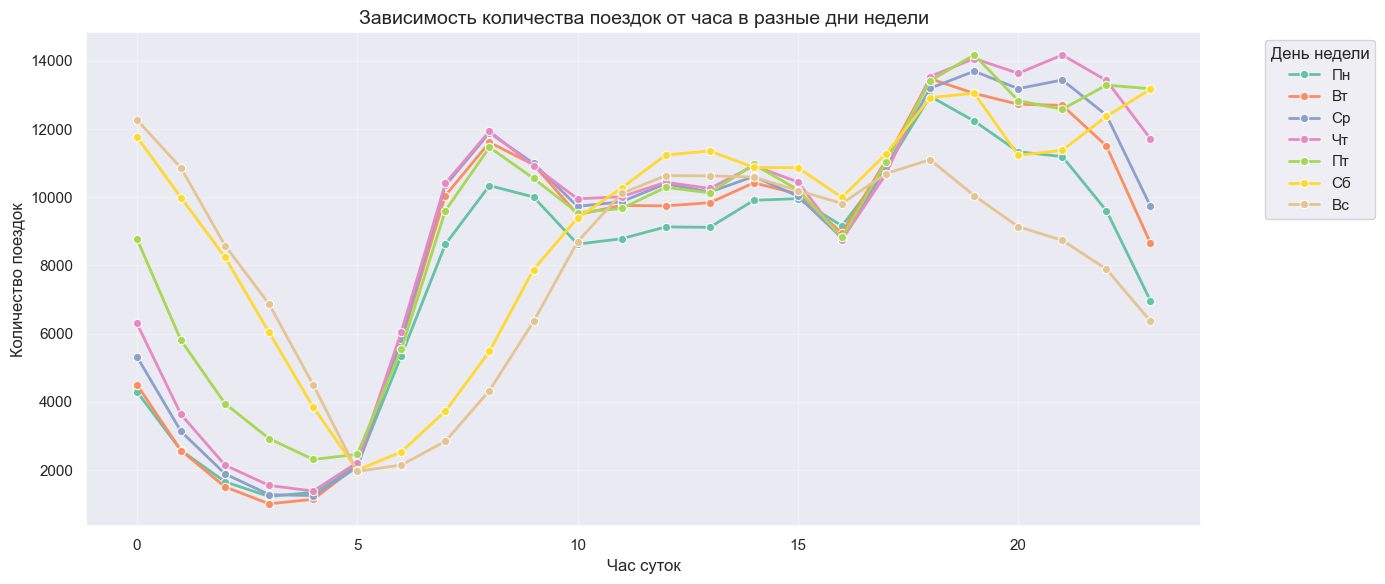

<Figure size 640x480 with 0 Axes>

In [26]:
# График зависимости количества поездок от часа для разных дней недели
plt.figure(figsize=(14, 6))

hour_weekday_counts = df.groupby(['hour', 'day_of_week']).size().reset_index(name='count')
day_names_dict = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
hour_weekday_counts['day_name'] = hour_weekday_counts['day_of_week'].map(day_names_dict)

sns.lineplot(data=hour_weekday_counts, x='hour', y='count', hue='day_name',
             palette='Set2', marker='o', linewidth=2)
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Зависимость количества поездок от часа в разные дни недели', fontsize=14)
plt.legend(title='День недели', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/trips_per_weekday_hour.png")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше?

**Ответ**:
1. **Часы суток**: Чётко выделяются пики в утренние часы (7-9) и вечерние часы (18-20), когда люди едут на работу и с работы. Минимум поездок наблюдается ночью (3-5 часов).

2. **Дни недели**: Пятница и суббота выделяются большим количеством поездок в вечернее время (19-23 часа), что связано с развлечениями и ночной жизнью. В будние дни более выражены утренние и вечерние пики.

3. **Месяцы**: Разница между месяцами относительно небольшая.

### Задание 4: Анализ таргета по времени

In [27]:
# Разбиваем на train и test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")

Размер обучающей выборки: (1021050, 15)
Размер тестовой выборки: (437594, 15)


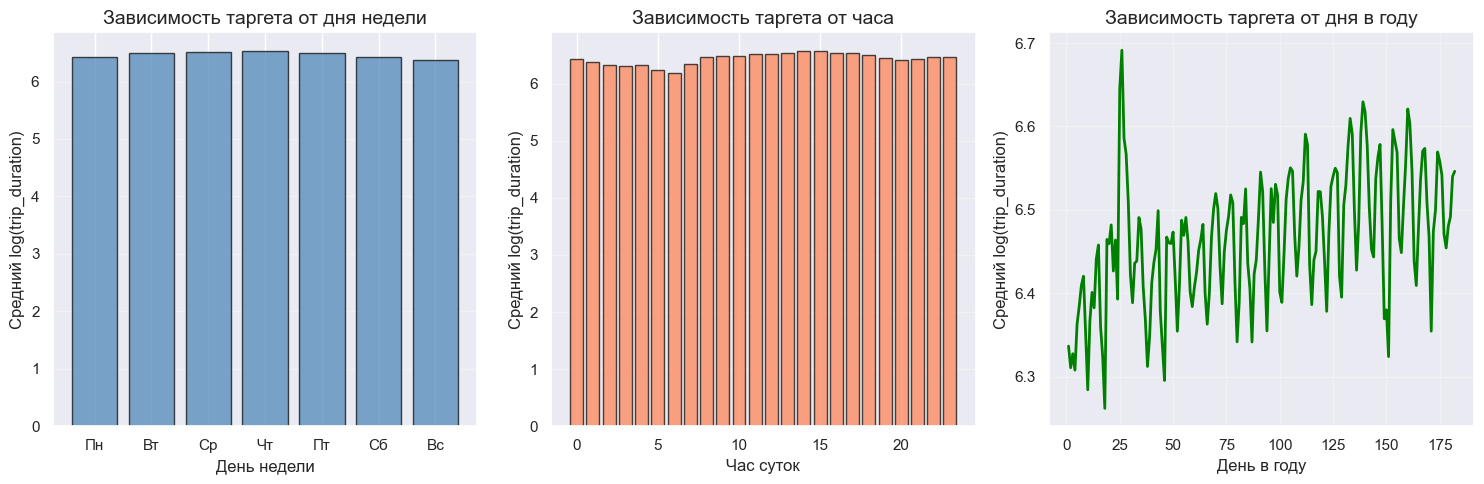

<Figure size 640x480 with 0 Axes>

In [28]:
# График зависимости среднего log_trip_duration от дня недели
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
weekday_means = train_df.groupby('day_of_week')['log_trip_duration'].mean()
plt.bar(range(7), weekday_means.values, edgecolor='black', alpha=0.7, color='steelblue')
plt.xticks(range(7), day_names)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Средний log(trip_duration)', fontsize=12)
plt.title('Зависимость таргета от дня недели', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# График зависимости от часа
plt.subplot(1, 3, 2)
hour_means = train_df.groupby('hour')['log_trip_duration'].mean()
plt.bar(hour_means.index, hour_means.values, edgecolor='black', alpha=0.7, color='coral')
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('Средний log(trip_duration)', fontsize=12)
plt.title('Зависимость таргета от часа', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# График зависимости от дня в году
plt.subplot(1, 3, 3)
day_means = train_df.groupby('day_of_year')['log_trip_duration'].mean()
plt.plot(day_means.index, day_means.values, linewidth=2, color='green')
plt.xlabel('День в году', fontsize=12)
plt.ylabel('Средний log(trip_duration)', fontsize=12)
plt.title('Зависимость таргета от дня в году', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/target_dependency.png")

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему?

**Ответ**: Графики не похожи, более того, они часто противоположны:
- Когда количество поездок минимально (ночные часы 3-5), средняя длительность МАКСИМАЛЬНА
- Когда количество поездок максимально (час пик), средняя длительность ниже

Это объясняется загруженностью дорог: в час пик много поездок, но они короче из-за пробок и низкой скорости. Ночью поездок мало, но те, что есть, длиннее из-за свободных дорог и более дальних направлений.

**Что происходит в аномальные периоды**: В дни снежной бури (23-24 января) средняя длительность резко возрастает - люди ездили только по необходимости, на дальние расстояния, при плохих дорожных условиях.

**Тренд по дням года**: Наблюдается небольшой рост средней длительности от начала года к середине, что может быть связано с улучшением погодных условий и увеличением дальних поездок.

In [29]:
# Создаем признаки на основе времени
# Определяем аномальные периоды
train_df['is_blizzard'] = ((train_df['day_of_year'] >= 23) &
                            (train_df['day_of_year'] <= 25)).astype(int)
test_df['is_blizzard'] = ((test_df['day_of_year'] >= 23) &
                           (test_df['day_of_year'] <= 25)).astype(int)

# Новогодние праздники
train_df['is_new_year'] = ((train_df['day_of_year'] >= 1) &
                            (train_df['day_of_year'] <= 3)).astype(int)
test_df['is_new_year'] = ((test_df['day_of_year'] >= 1) &
                           (test_df['day_of_year'] <= 3)).astype(int)

print("Добавлены признаки аномальных периодов")
print(f"Количество поездок во время снежной бури: {train_df['is_blizzard'].sum()}")
print(f"Количество поездок в новогодние праздники: {train_df['is_new_year'].sum()}")

Добавлены признаки аномальных периодов
Количество поездок во время снежной бури: 7828
Количество поездок в новогодние праздники: 14034


**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные?

**Ответ**:
- **Категориальные**: `day_of_week`, `month`, `hour` - это циклические категории без естественного порядка величин.
- **Численные**: `day_of_year` - имеет линейный тренд, `is_blizzard`, `is_new_year` - бинарные признаки.

Категориальные признаки лучше кодировать через One-Hot Encoding, чтобы модель не предполагала линейную зависимость.

### Задание 5: Первая модель

In [30]:
# Создаем список признаков
categorical_features = ['day_of_week', 'month', 'hour']
numerical_features = ['day_of_year', 'is_blizzard', 'is_new_year']

# Создаем препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Создаем pipeline
model_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Обучаем модель
X_train = train_df[categorical_features + numerical_features]
y_train = train_df['log_trip_duration']
X_test = test_df[categorical_features + numerical_features]
y_test = test_df['log_trip_duration']

model_1.fit(X_train, y_train)

# Предсказания
y_pred_train = model_1.predict(X_train)
y_pred_test = model_1.predict(X_test)

# Оценка качества
rmsle_train_1 = rmsle(y_train, y_pred_train)
rmsle_test_1 = rmsle(y_test, y_pred_test)

print("=" * 50)
print("Модель 1: Признаки на основе времени")
print("=" * 50)
print(f"RMSLE на обучающей выборке: {rmsle_train_1:.5f}")
print(f"RMSLE на тестовой выборке: {rmsle_test_1:.5f}")
print(f"Улучшение по сравнению с константой: {(rmsle_best_const - rmsle_test_1) / rmsle_best_const * 100:.2f}%")

Модель 1: Признаки на основе времени
RMSLE на обучающей выборке: 0.78901
RMSLE на тестовой выборке: 0.78807
Улучшение по сравнению с константой: 0.97%


# Часть 2. Изучаем координаты

Функция которая на карте рисует точки начала или конца поездки

In [31]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [32]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [33]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос:** Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?
**Ответ:**
- JFK Airport (Аэропорт Кеннеди): Четко видно изолированное скопление точек, отделенное от основной массы. Один из крупнейших аэропортов мира с постоянным потоком такси.
- LaGuardia Airport (Аэропорт Ла Гуардия): Видно отдельное скопление севернее центрального массива. Второй крупный аэропорт, обслуживающий в основном внутренние рейсы.
- Penn Station / Центральный Манхэттен: Максимальная плотность точек - виден почти сплошной синий массив. Penn Station - крупнейший ж/д вокзал, деловой и туристический центр.

Почему эти признаки полезны для модели? Разная средняя длительность:
1. JFK: ~45-60 минут
2. LaGuardia: ~30-40 минут
3. Penn Station (внутри города): ~10-20 минут
Разные паттерны трафика: Аэропорты меньше зависят от rush hour (едут по хайвеям), центр города сильно зависит от времени суток. Улучшение предсказаний: Эти бинарные признаки помогают модели "понять", что поездка из определенной локации имеет специфичное распределение длительности.

## Задание 6: Расстояние Haversine

In [34]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Вычисляет расстояние между двумя точками на Земле используя формулу Haversine
    Возвращает расстояние в километрах
    """
    # Радиус Земли в километрах
    R = 6371.0

    # Переводим градусы в радианы
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Разница координат
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Формула Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

In [35]:
# Вычисляем расстояние для train и test
train_df['haversine'] = haversine_distance(
    train_df['pickup_latitude'], train_df['pickup_longitude'],
    train_df['dropoff_latitude'], train_df['dropoff_longitude']
)

test_df['haversine'] = haversine_distance(
    test_df['pickup_latitude'], test_df['pickup_longitude'],
    test_df['dropoff_latitude'], test_df['dropoff_longitude']
)

In [36]:
# Добавляем логарифм расстояния
train_df['log_haversine'] = np.log1p(train_df['haversine'])
test_df['log_haversine'] = np.log1p(test_df['haversine'])

print(f"Статистика по расстоянию Haversine:")
print(train_df['haversine'].describe())
print(f"Статистика по log(haversine):")
print(train_df['log_haversine'].describe())

Статистика по расстоянию Haversine:
count    1.021050e+06
mean     3.443973e+00
std      4.361104e+00
min      0.000000e+00
25%      1.231736e+00
50%      2.095418e+00
75%      3.879408e+00
max      1.240909e+03
Name: haversine, dtype: float64
Статистика по log(haversine):
count    1.021050e+06
mean     1.255125e+00
std      6.273159e-01
min      0.000000e+00
25%      8.027797e-01
50%      1.129923e+00
75%      1.585024e+00
max      7.124405e+00
Name: log_haversine, dtype: float64


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [37]:
corr_haversine = train_df['haversine'].corr(train_df['log_trip_duration'])
corr_log_haversine = train_df['log_haversine'].corr(train_df['log_trip_duration'])

print(f"Корреляция haversine с таргетом: {corr_haversine:.4f}")
print(f"Корреляция log_haversine с таргетом: {corr_log_haversine:.4f}")

assert train_df['log_haversine'].corr(train_df['log_trip_duration']) > train_df['haversine'].corr(train_df['log_trip_duration'])

Корреляция haversine с таргетом: 0.5654
Корреляция log_haversine с таргетом: 0.7500


## Задание 7: Анализ скорости

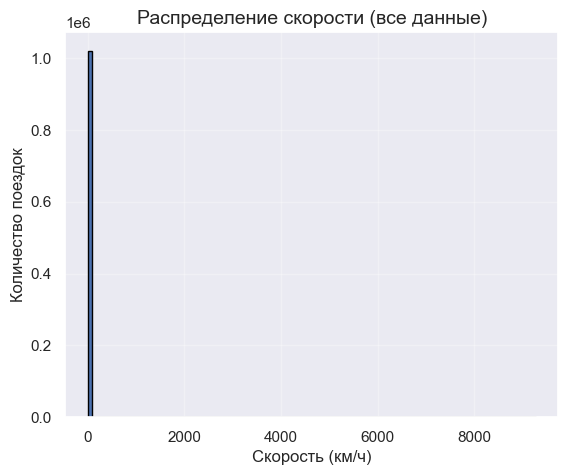

In [38]:
# Вычисляем скорость (км/ч)
train_df_with_speed = train_df.copy()
# Переводим секунды в часы
train_df_with_speed['speed'] = train_df_with_speed['haversine'] / (np.expm1(train_df_with_speed['log_trip_duration']) / 3600)

# Гистограмма всех скоростей
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.hist(train_df_with_speed['speed'], bins=100, edgecolor='black')
plt.xlabel('Скорость (км/ч)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title('Распределение скорости (все данные)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig("data/output/laboratory_work2/speed_distribution_all.png")

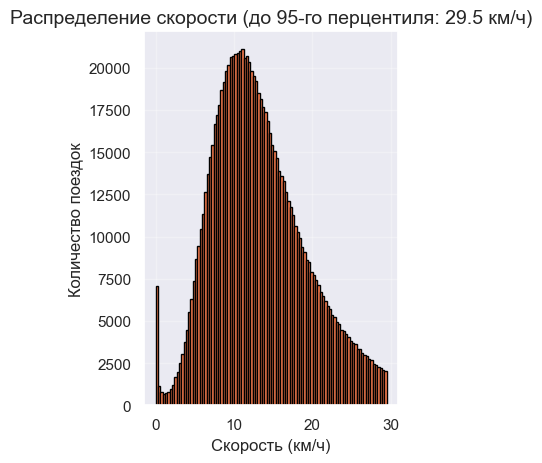

Статистика по скорости: count    1.021050e+06
mean     1.443489e+01
std      1.559053e+01
min      0.000000e+00
25%      9.128732e+00
50%      1.279986e+01
75%      1.785195e+01
max      9.274837e+03
Name: speed, dtype: float64


<Figure size 640x480 with 0 Axes>

In [39]:
# Гистограмма разумных скоростей (до 95-го перцентиля)
plt.subplot(1, 2, 2)
speed_95 = train_df_with_speed['speed'].quantile(0.95)
reasonable_speeds = train_df_with_speed[train_df_with_speed['speed'] <= speed_95]['speed']
plt.hist(reasonable_speeds, bins=100, edgecolor='black', color='coral')
plt.xlabel('Скорость (км/ч)', fontsize=12)
plt.ylabel('Количество поездок', fontsize=12)
plt.title(f'Распределение скорости (до 95-го перцентиля: {speed_95:.1f} км/ч)', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/speed_distribution_reasonable.png")

print(f"Статистика по скорости: {train_df_with_speed['speed'].describe()}")

Медиана скоростей по дням недели и часам:

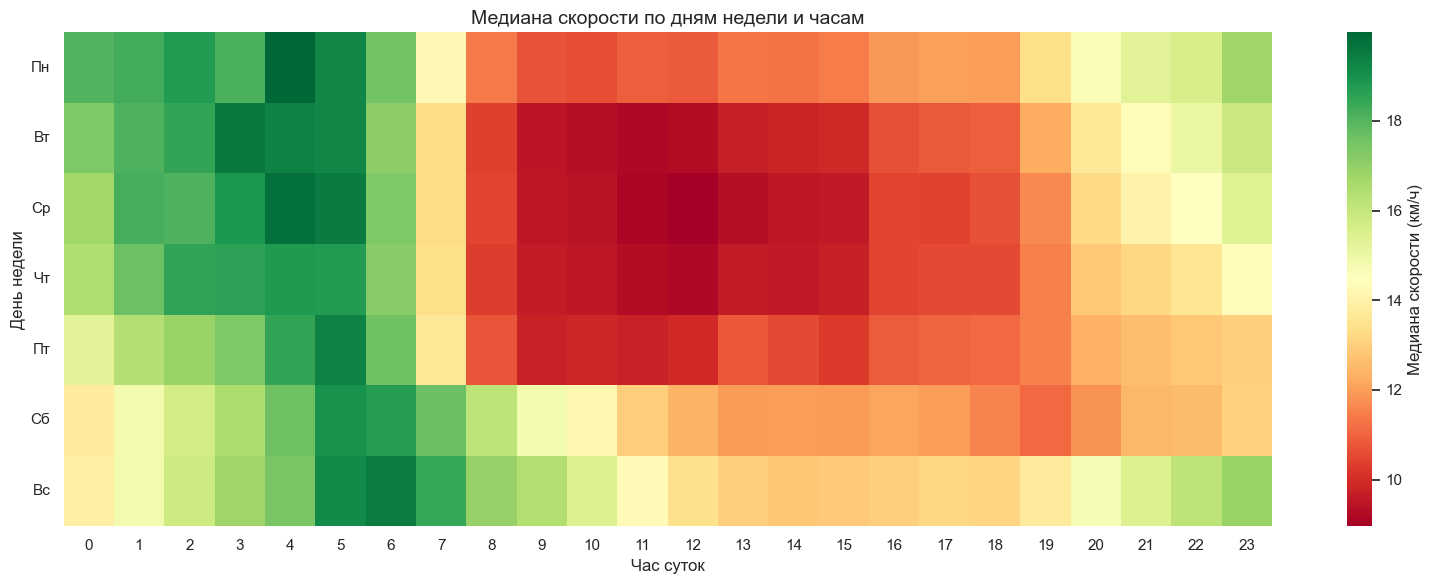

<Figure size 640x480 with 0 Axes>

In [40]:
# Вычисляем медиану скоростей для каждой пары (день недели, час)
speed_heatmap = train_df_with_speed[train_df_with_speed['speed'] <= speed_95].groupby(
    ['day_of_week', 'hour'])['speed'].median().reset_index()

# Создаем pivot таблицу для heatmap
speed_pivot = speed_heatmap.pivot(index='day_of_week', columns='hour', values='speed')

# Рисуем heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(speed_pivot, annot=False, cmap='RdYlGn', cbar_kws={'label': 'Медиана скорости (км/ч)'})
plt.xlabel('Час суток', fontsize=12)
plt.ylabel('День недели', fontsize=12)
plt.yticks(np.arange(7) + 0.5, ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], rotation=0)
plt.title('Медиана скорости по дням недели и часам', fontsize=14)
plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/speed_heatmap.png")

**Вопрос:** Почему значение скорости нельзя использовать во время обучения?

**Ответ**: Скорость вычисляется как расстояние / время, где время - это наша целевая переменная (trip_duration). Использование скорости означало бы использование информации о целевой переменной. На тестовых данных у нас не будет значения trip_duration, поэтому мы не сможем вычислить скорость.

**Вопрос**: В какие моменты времени скорость минимальна/максимальна?

**Ответ**:
- **Минимальная скорость**: в будние дни (Пн-Пт) в утренние часы (7-9) и вечерние часы (17-19) - час пик, пробки
- **Максимальная скорость**: ночные и ранние утренние часы (0-5), а также выходные дни - свободные дороги

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог":

In [41]:
# Создаем признаки на основе анализа скорости
# Период пробок: будни 7-9 и 17-19
train_df['is_rush_hour'] = (
    (train_df['day_of_week'] < 5) &  # Будние дни
    (((train_df['hour'] >= 7) & (train_df['hour'] <= 9)) |
     ((train_df['hour'] >= 17) & (train_df['hour'] <= 19)))
).astype(int)

test_df['is_rush_hour'] = (
    (test_df['day_of_week'] < 5) &
    (((test_df['hour'] >= 7) & (test_df['hour'] <= 9)) |
     ((test_df['hour'] >= 17) & (test_df['hour'] <= 19)))
).astype(int)

# Период свободных дорог: ночные часы 0-5
train_df['is_free_traffic'] = ((train_df['hour'] >= 0) & (train_df['hour'] <= 5)).astype(int)
test_df['is_free_traffic'] = ((test_df['hour'] >= 0) & (test_df['hour'] <= 5)).astype(int)

print(f"Поездок в час пик: {train_df['is_rush_hour'].sum()} ({train_df['is_rush_hour'].mean()*100:.1f}%)")
print(f"Поездок в период свободных дорог: {train_df['is_free_traffic'].sum()} ({train_df['is_free_traffic'].mean()*100:.1f}%)")

Поездок в час пик: 243927 (23.9%)
Поездок в период свободных дорог: 120166 (11.8%)


## Задание 8: Признаки важных точек

Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:

- Началась ли поездка в этом пункте
- Закончилась ли поездка в этом пункте


**Важные точки на карте Манхэттена:**
1. **JFK Airport** (аэропорт): 40.6413, -73.7781
2. **LaGuardia Airport** (аэропорт): 40.7769, -73.8740
3. **Penn Station** (вокзал): 40.7505, -73.9934

In [42]:
# Функция для проверки близости к точке
def is_near_location(lat, lon, target_lat, target_lon, threshold_km=0.5):
    """Проверяет, находится ли точка в пределах threshold_km от целевой точки"""
    dist = haversine_distance(lat, lon, target_lat, target_lon)
    return (dist <= threshold_km).astype(int)

In [43]:
# JFK Airport
jfk_lat, jfk_lon = 40.6413, -73.7781
train_df['pickup_jfk'] = is_near_location(train_df['pickup_latitude'], train_df['pickup_longitude'], jfk_lat, jfk_lon)
train_df['dropoff_jfk'] = is_near_location(train_df['dropoff_latitude'], train_df['dropoff_longitude'], jfk_lat, jfk_lon)
test_df['pickup_jfk'] = is_near_location(test_df['pickup_latitude'], test_df['pickup_longitude'], jfk_lat, jfk_lon)
test_df['dropoff_jfk'] = is_near_location(test_df['dropoff_latitude'], test_df['dropoff_longitude'], jfk_lat, jfk_lon)

In [44]:
# LaGuardia Airport
lga_lat, lga_lon = 40.7769, -73.8740
train_df['pickup_lga'] = is_near_location(train_df['pickup_latitude'], train_df['pickup_longitude'], lga_lat, lga_lon)
train_df['dropoff_lga'] = is_near_location(train_df['dropoff_latitude'], train_df['dropoff_longitude'], lga_lat, lga_lon)
test_df['pickup_lga'] = is_near_location(test_df['pickup_latitude'], test_df['pickup_longitude'], lga_lat, lga_lon)
test_df['dropoff_lga'] = is_near_location(test_df['dropoff_latitude'], test_df['dropoff_longitude'], lga_lat, lga_lon)

In [45]:
# Penn Station
penn_lat, penn_lon = 40.7505, -73.9934
train_df['pickup_penn'] = is_near_location(train_df['pickup_latitude'], train_df['pickup_longitude'], penn_lat, penn_lon)
train_df['dropoff_penn'] = is_near_location(train_df['dropoff_latitude'], train_df['dropoff_longitude'], penn_lat, penn_lon)
test_df['pickup_penn'] = is_near_location(test_df['pickup_latitude'], test_df['pickup_longitude'], penn_lat, penn_lon)
test_df['dropoff_penn'] = is_near_location(test_df['dropoff_latitude'], test_df['dropoff_longitude'], penn_lat, penn_lon)

In [46]:
print("Добавлены признаки важных точек:")
print(f"JFK - начало: {train_df['pickup_jfk'].sum()}, конец: {train_df['dropoff_jfk'].sum()}")
print(f"LaGuardia - начало: {train_df['pickup_lga'].sum()}, конец: {train_df['dropoff_lga'].sum()}")
print(f"Penn Station - начало: {train_df['pickup_penn'].sum()}, конец: {train_df['dropoff_penn'].sum()}")

Добавлены признаки важных точек:
JFK - начало: 6853, конец: 1845
LaGuardia - начало: 13488, конец: 6379
Penn Station - начало: 48788, конец: 40859


**Почему эти признаки могут быть полезны:**
- Аэропорты - это специфические поездки с предсказуемой длительностью
- Вокзалы - важные транспортные узлы с большим потоком пассажиров

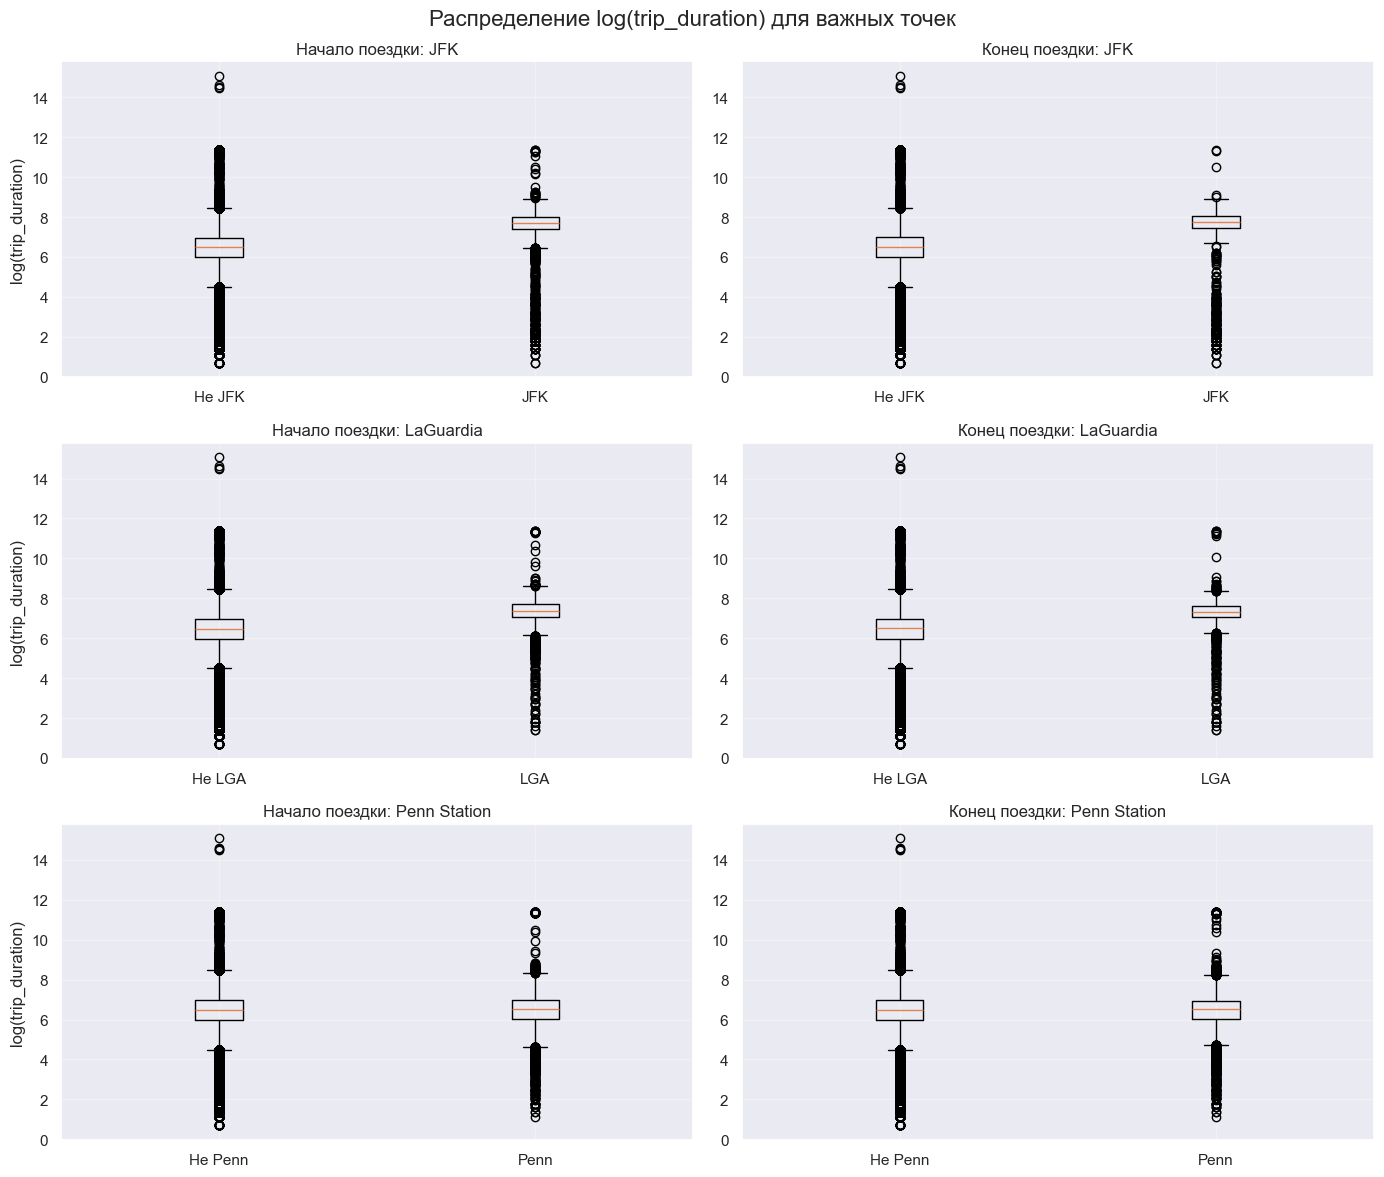

<Figure size 640x480 with 0 Axes>

In [47]:
# Визуализируем распределение таргета для каждого признака
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Распределение log(trip_duration) для важных точек', fontsize=16)

# JFK
axes[0, 0].boxplot([train_df[train_df['pickup_jfk']==0]['log_trip_duration'],
                     train_df[train_df['pickup_jfk']==1]['log_trip_duration']],
                    labels=['Не JFK', 'JFK'])
axes[0, 0].set_title('Начало поездки: JFK')
axes[0, 0].set_ylabel('log(trip_duration)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].boxplot([train_df[train_df['dropoff_jfk']==0]['log_trip_duration'],
                     train_df[train_df['dropoff_jfk']==1]['log_trip_duration']],
                    labels=['Не JFK', 'JFK'])
axes[0, 1].set_title('Конец поездки: JFK')
axes[0, 1].grid(True, alpha=0.3)

# LaGuardia
axes[1, 0].boxplot([train_df[train_df['pickup_lga']==0]['log_trip_duration'],
                     train_df[train_df['pickup_lga']==1]['log_trip_duration']],
                    labels=['Не LGA', 'LGA'])
axes[1, 0].set_title('Начало поездки: LaGuardia')
axes[1, 0].set_ylabel('log(trip_duration)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].boxplot([train_df[train_df['dropoff_lga']==0]['log_trip_duration'],
                     train_df[train_df['dropoff_lga']==1]['log_trip_duration']],
                    labels=['Не LGA', 'LGA'])
axes[1, 1].set_title('Конец поездки: LaGuardia')
axes[1, 1].grid(True, alpha=0.3)

# Penn Station
axes[2, 0].boxplot([train_df[train_df['pickup_penn']==0]['log_trip_duration'],
                     train_df[train_df['pickup_penn']==1]['log_trip_duration']],
                    labels=['Не Penn', 'Penn'])
axes[2, 0].set_title('Начало поездки: Penn Station')
axes[2, 0].set_ylabel('log(trip_duration)')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].boxplot([train_df[train_df['dropoff_penn']==0]['log_trip_duration'],
                     train_df[train_df['dropoff_penn']==1]['log_trip_duration']],
                    labels=['Не Penn', 'Penn'])
axes[2, 1].set_title('Конец поездки: Penn Station')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig("data/output/laboratory_work2/important_locations_distribution.png")

**Вопрос**: Судя по графикам, хорошими ли получились эти признаки?

**Ответ**: Да, признаки получились хорошими! Для JFK и LaGuardia видно, что медиана длительности поездки значительно выше, что логично - аэропорты находятся дальше от центра. Penn Station показывает меньшую разницу, но признак все равно полезен.

## Задание 9: MapGridTransformer

In [48]:
class MapGridTransformer(BaseEstimator, TransformerMixin):
    """
    Трансформер для создания признаков на основе разбиения карты на ячейки
    """
    def __init__(self, n_rows=20, n_cols=20):
        self.n_rows = n_rows
        self.n_cols = n_cols
        # Границы области Манхэттена
        self.lat_min = 40.6
        self.lat_max = 40.9
        self.lon_min = -74.05
        self.lon_max = -73.75

    def fit(self, X, y=None):
        # Вычисляем размеры ячеек
        self.lat_step = (self.lat_max - self.lat_min) / self.n_rows
        self.lon_step = (self.lon_max - self.lon_min) / self.n_cols
        return self

    def _get_cell_id(self, lat, lon):
        """Возвращает номер ячейки для координат"""
        # Проверяем, попадают ли координаты в область
        mask = ((lat >= self.lat_min) & (lat <= self.lat_max) &
                (lon >= self.lon_min) & (lon <= self.lon_max))

        # Вычисляем индексы строки и столбца
        row_idx = ((lat - self.lat_min) / self.lat_step).astype(int)
        col_idx = ((lon - self.lon_min) / self.lon_step).astype(int)

        # Ограничиваем индексы
        row_idx = np.clip(row_idx, 0, self.n_rows - 1)
        col_idx = np.clip(col_idx, 0, self.n_cols - 1)

        # Вычисляем ID ячейки
        cell_id = row_idx * self.n_cols + col_idx

        # Устанавливаем -1 для точек вне области
        cell_id = np.where(mask, cell_id, -1)

        return cell_id

    def transform(self, X, y=None):
        """Добавляет признаки номеров ячеек для начала и конца поездки"""
        X_copy = X.copy()

        X_copy['pickup_cell'] = self._get_cell_id(
            X_copy['pickup_latitude'].values,
            X_copy['pickup_longitude'].values
        )

        X_copy['dropoff_cell'] = self._get_cell_id(
            X_copy['dropoff_latitude'].values,
            X_copy['dropoff_longitude'].values
        )

        return X_copy

    def show_map(self, data_sample):
        """Визуализирует разбиение на ячейки"""
        m = folium.Map(
            location=[(self.lat_min + self.lat_max)/2, (self.lon_min + self.lon_max)/2],
            zoom_start=11
        )

        # Рисуем сетку
        for i in range(self.n_rows + 1):
            lat = self.lat_min + i * self.lat_step
            folium.PolyLine(
                locations=[[lat, self.lon_min], [lat, self.lon_max]],
                color='blue',
                weight=1,
                opacity=0.5
            ).add_to(m)

        for j in range(self.n_cols + 1):
            lon = self.lon_min + j * self.lon_step
            folium.PolyLine(
                locations=[[self.lat_min, lon], [self.lat_max, lon]],
                color='blue',
                weight=1,
                opacity=0.5
            ).add_to(m)

        return m

In [49]:
# Применяем трансформер
grid_transformer = MapGridTransformer(n_rows=20, n_cols=20)
grid_transformer.fit(train_df)

train_df = grid_transformer.transform(train_df)
test_df = grid_transformer.transform(test_df)

print("Добавлены признаки ячеек:")
print(f"Уникальных ячеек для начала: {train_df['pickup_cell'].nunique()}")
print(f"Уникальных ячеек для конца: {train_df['dropoff_cell'].nunique()}")
print(f"Поездок вне области (pickup): {(train_df['pickup_cell'] == -1).sum()}")
print(f"Поездок вне области (dropoff): {(train_df['dropoff_cell'] == -1).sum()}")

Добавлены признаки ячеек:
Уникальных ячеек для начала: 306
Уникальных ячеек для конца: 354
Поездок вне области (pickup): 585
Поездок вне области (dropoff): 5067


## Задание 10: Модель с координатными признаками

In [50]:
# Обновляем списки признаков
categorical_features_2 = ['day_of_week', 'month', 'hour', 'pickup_cell', 'dropoff_cell']
numerical_features_2 = [
    'day_of_year', 'is_blizzard', 'is_new_year',
    'log_haversine', 'is_rush_hour', 'is_free_traffic',
    'pickup_jfk', 'dropoff_jfk', 'pickup_lga', 'dropoff_lga',
    'pickup_penn', 'dropoff_penn'
]

In [51]:
# Создаем препроцессор
preprocessor_2 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features_2),
        (
            "cat",
            OneHotEncoder(
                drop="first",
                sparse_output=True,
                handle_unknown="ignore",
            ),
            categorical_features_2,
        ),
    ],
    sparse_threshold=0.3
)

In [52]:
# Создаем и обучаем модель
model_2 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('regressor', Ridge())
])

X_train_2 = train_df[categorical_features_2 + numerical_features_2]
X_test_2 = test_df[categorical_features_2 + numerical_features_2]

model_2.fit(X_train_2, y_train)

y_pred_train_2 = model_2.predict(X_train_2)
y_pred_test_2 = model_2.predict(X_test_2)

rmsle_train_2 = rmsle(y_train, y_pred_train_2)
rmsle_test_2 = rmsle(y_test, y_pred_test_2)

print("=" * 50)
print("Модель 2: С признаками координат")
print("=" * 50)
print(f"RMSLE на обучающей выборке: {rmsle_train_2:.5f}")
print(f"RMSLE на тестовой выборке: {rmsle_test_2:.5f}")
print(f"Улучшение по сравнению с Моделью 1: {(rmsle_test_1 - rmsle_test_2) / rmsle_test_1 * 100:.2f}%")

Модель 2: С признаками координат
RMSLE на обучающей выборке: 0.47008
RMSLE на тестовой выборке: 0.47011
Улучшение по сравнению с Моделью 1: 40.35%
